In [32]:
import pandas as pd
import matplotlib.pyplot as plt

In [66]:
# map likert to numeric values
def likert_to_numeric(likert_value):
    likert_map = {
        "Strongly Disagree": 1,
        "Strongly disagree": 1,
        "Disagree": 2,
        "Neither agree or disagree": 3,
        "Agree": 4,
        "Strongly Agree": 5
    }
    return likert_map.get(likert_value, None)

In [48]:
pre_task = pd.read_csv('data/preTask.csv')

# skip first two rows
pre_task = pre_task.iloc[2:]
pre_task_cols = ['Q1', 'Q3', 'Q4', 'Q7_1', 'Q7_2', 'Q7_3', 'Q7_4', 'Q7_5', 'Q7_6', 'Q8_1', 'Q8_2', 'Q8_3', 'Q8_4']

trust_pretask = ['trust_operate', 'trust_comfort', 'trust_depend', 'trust_cautious', 'trust_trustworthy', 'attention_check_disagree']
familiar_pretask = ['familiar_1', 'familiar_2', 'familiar_3', 'familiar_4']
pre_task_col_names = ['consent', 'gender', 'age'] + trust_pretask + familiar_pretask


pre_task = pre_task[pre_task_cols]
pre_task.columns = pre_task_col_names

# map trust_pretask and familiar_pretask to numeric values
for col in trust_pretask + familiar_pretask:
    pre_task[col] = pre_task[col].apply(likert_to_numeric)
    
# final_trust score is the average of trust_pretask columns
pre_task['final_trust'] = pre_task[trust_pretask].mean(axis=1)
# final_familiar score is the average of familiar_pretask columns
pre_task['final_familiar'] = pre_task[familiar_pretask].mean(axis=1)

# check if attention check is passed (equals to 2)
pre_task['pre_task_attention'] = pre_task['attention_check_disagree'] == 2

# print the number of participants who failed the attention check
print(f"Number of participants who failed the attention check: {len(pre_task[~pre_task['pre_task_attention']])}")

pre_task.reset_index(drop=True, inplace=True)
display(pre_task)

Number of participants who failed the attention check: 0


,consent,gender,age,trust_operate,trust_comfort,trust_depend,trust_cautious,trust_trustworthy,attention_check_disagree,familiar_1,familiar_2,familiar_3,familiar_4,final_trust,final_familiar,pre_task_attention
0,"I consent, begin the study",Male,21 - 25,4,2,4,3,4,2,4,4,4,4,3.166667,4.00,True
1,"I consent, begin the study",Male,16 - 20,2,3,4,4,3,2,4,5,5,2,3.000000,4.00,True
2,"I consent, begin the study",Female,21 - 25,2,3,3,4,3,2,4,5,5,5,2.833333,4.75,True
3,"I consent, begin the study",Female,21 - 25,3,4,4,4,3,2,5,4,4,5,3.333333,4.50,True
4,"I consent, begin the study",Male,16 - 20,4,2,4,4,5,2,5,5,5,3,3.500000,4.50,True
5,"I consent, begin the study",Male,21 - 25,5,3,5,4,4,2,5,5,5,5,3.833333,5.00,True
6,"I consent, begin the study",Female,21 - 25,4,4,4,5,3,2,5,5,4,5,3.666667,4.75,True
7,"I consent, begin the study",Male,16 - 20,2,2,3,4,3,2,4,4,4,4,2.666667,4.00,True
8,"I consent, begin the study",Male,16 - 20,2,2,2,4,3,2,5,5,5,4,2.500000,4.75,True


In [49]:
task_data = pd.read_csv('data/task.csv')

scenarios = ['Interpersonal Relations and Self-Concept', 'Tastes and Interests', 'Work or Studies']
sensitivity = ['Low', 'Medium', 'High']
willingness = [1, 2, 3, 4, 5]

task_cols = ['user_id', 'condition', 'study', 'scenario', 'question', 'question_sensitivity', 'user_willingness', 'user_sensitivity']

# compute for each condition the average willingness and sensitivity
task_data = task_data[task_cols]

/var/folders/qy/ygkmp05928xgqsht5dtl278r0000gn/T/ipykernel_78821/3877754381.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot(


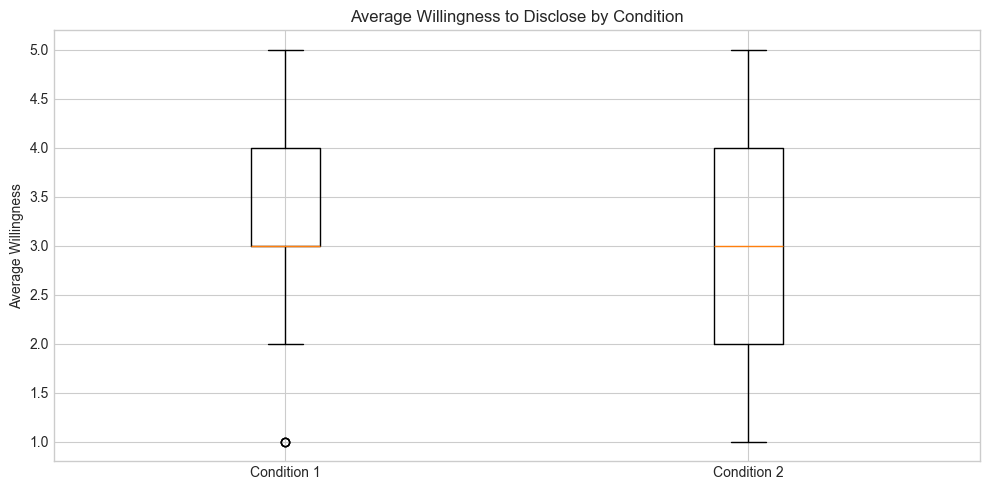

In [50]:
# First plot: Willingness by condition
fig1, ax1 = plt.subplots(figsize=(10, 5))
ax1.boxplot(
    [task_data[task_data['condition'] == 1]['user_willingness'],
     task_data[task_data['condition'] == 2]['user_willingness']],
    labels=['Condition 1', 'Condition 2']
)
ax1.set_title('Average Willingness to Disclose by Condition')
ax1.set_ylabel('Average Willingness')
plt.tight_layout()
plt.show()

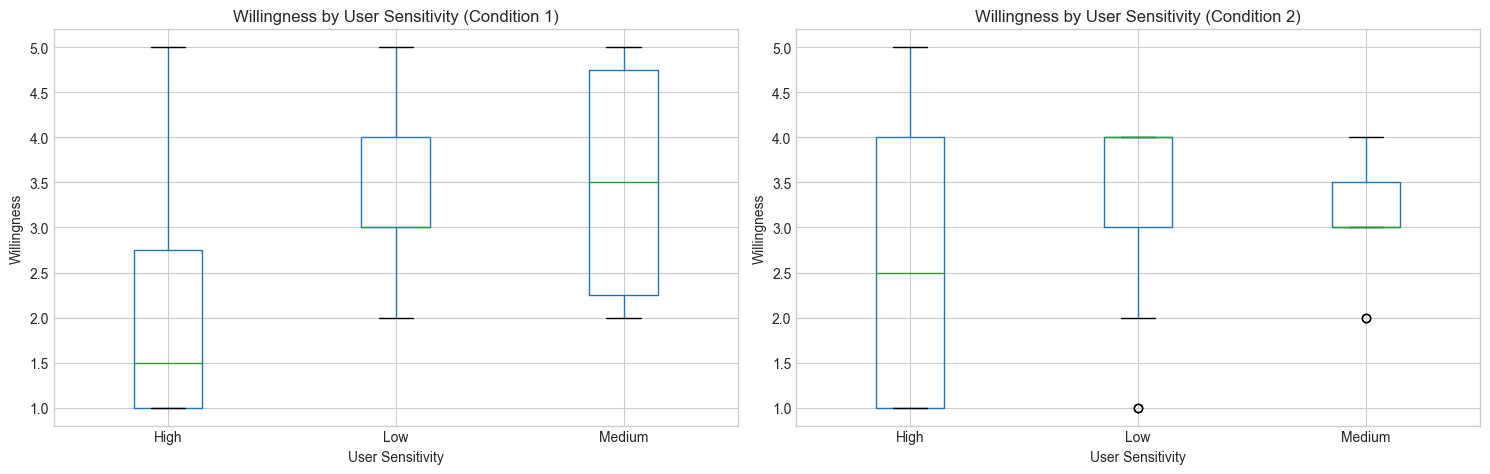

In [51]:
# Second plot: Willingness by sensitivity for each condition
fig2, axes2 = plt.subplots(1, 2, figsize=(15, 5))

# Boxplot for willingness by sensitivity for condition 1
task_data[task_data['condition'] == 1].boxplot(column='user_willingness', by='user_sensitivity', ax=axes2[0])
axes2[0].set_title('Willingness by User Sensitivity (Condition 1)')
axes2[0].set_xlabel('User Sensitivity')
axes2[0].set_ylabel('Willingness')
axes2[0].get_figure().suptitle('')

# Boxplot for willingness by sensitivity for condition 2
task_data[task_data['condition'] == 2].boxplot(column='user_willingness', by='user_sensitivity', ax=axes2[1])
axes2[1].set_title('Willingness by User Sensitivity (Condition 2)')
axes2[1].set_xlabel('User Sensitivity')
axes2[1].set_ylabel('Willingness')
axes2[1].get_figure().suptitle('')

plt.tight_layout()
plt.show()

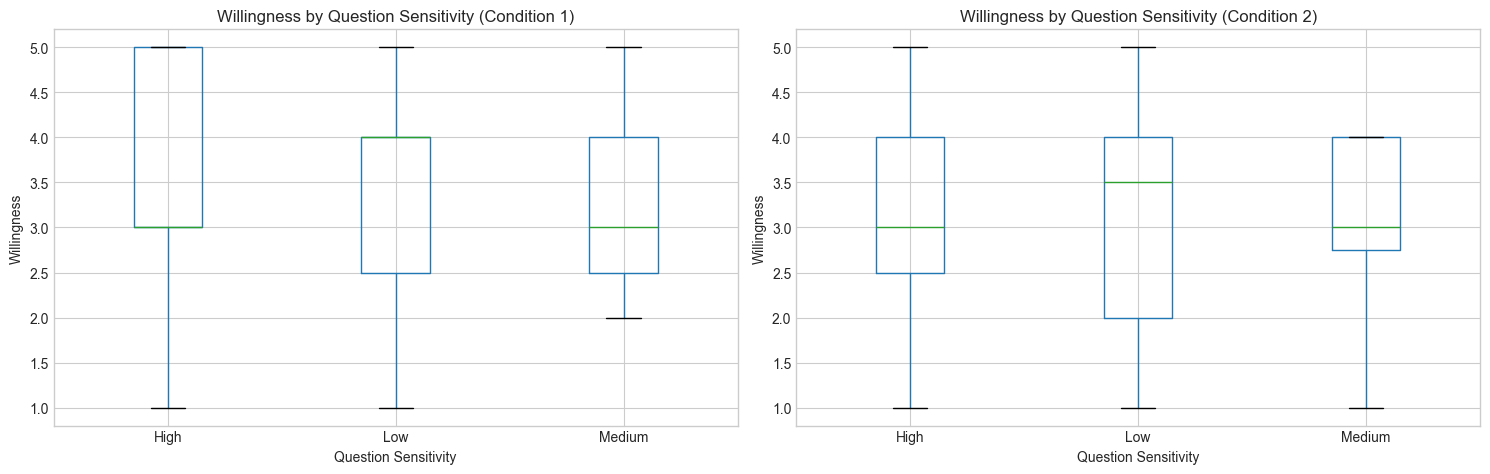

In [52]:
#  Now for by question_sensitivity
fig3, axes3 = plt.subplots(1, 2, figsize=(15, 5))
# Boxplot for willingness by question sensitivity for condition 1
task_data[task_data['condition'] == 1].boxplot(column='user_willingness', by='question_sensitivity', ax=axes3[0])
axes3[0].set_title('Willingness by Question Sensitivity (Condition 1)')
axes3[0].set_xlabel('Question Sensitivity')
axes3[0].set_ylabel('Willingness')
# Boxplot for willingness by question sensitivity for condition 2
task_data[task_data['condition'] == 2].boxplot(column='user_willingness', by='question_sensitivity', ax=axes3[1])
axes3[1].set_title('Willingness by Question Sensitivity (Condition 2)')
axes3[1].set_xlabel('Question Sensitivity')
axes3[1].set_ylabel('Willingness')
axes3[0].get_figure().suptitle('')

plt.tight_layout()
plt.show()

In [62]:
# replace godspeed entries that have  1 or 5 in the string with just 1 and 5
def replace_godspeed(value):
    if isinstance(value, str):
        if '1' in value:
            return 1
        elif '5' in value:
            return 5
    return value

In [ ]:
## Load data from qualtrics posttask
post_task = pd.read_csv('data/postTask.csv')

# skip first two rows and reset index
post_task = post_task.iloc[2:]
post_task.reset_index(drop=True, inplace=True)

post_task_cols = ['uid', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16_1', 'Q16_2', 'Q16_3', 'Q16_4', 'Q16_5', 'Q16_6']

anthropormorphism_godscale = ['godspeed_fake', 'godspeed_machinelike', 'godspeed_unconscious', 'godspeed_artificial', 'godspeed_rigid']
anthropormorphism_likert = ['likert_emotion', 'likert_humanlike', 'likert_style', 'likert_intentional', 'likert_another_person', 'attention_check_strongly_agree']

post_task_cols_names = ['user_id'] + anthropormorphism_godscale + anthropormorphism_likert 

post_task = post_task[post_task_cols]
post_task.columns = post_task_cols_names

# map godspeed entries to numeric values
for col in anthropormorphism_godscale:
    post_task[col] = post_task[col].apply(replace_godspeed)
    
for col in anthropormorphism_likert:
    post_task[col] = post_task[col].apply(likert_to_numeric)
    
# merge condition of task with post_task based on user_id (just get condition from task_data)
user_id_conds = task_data[['user_id', 'condition']].drop_duplicates()
post_task = post_task.merge(user_id_conds, on='user_id', how='left')

# compute final anthropomorphism score as the average of the godspeed and likert columns and convert to numeric
post_task[anthropormorphism_godscale + anthropormorphism_likert] = post_task[anthropormorphism_godscale + anthropormorphism_likert].apply(pd.to_numeric, errors='coerce')
post_task['final_anthropomorphism'] = post_task[anthropormorphism_godscale + anthropormorphism_likert].mean(axis=1)

# check if attention check is passed (equals to 5)
post_task['post_task_attention'] = post_task['attention_check_strongly_agree'] == 5
# print the number of participants who failed the attention check
print(f"Number of participants who failed the attention check: {len(post_task[~post_task['post_task_attention']])}")

display(post_task)

Number of participants who failed the attention check: 0


,user_id,godspeed_fake,godspeed_machinelike,godspeed_unconscious,godspeed_artificial,godspeed_rigid,likert_emotion,likert_humanlike,likert_style,likert_intentional,likert_another_person,attention_check_strongly_agree,condition,final_anthropomorphism,post_task_attention
0,R_8nuec0oZkEBN4WT,3,2,2,3,2,1,2,3,4,2,5,1,2.636364,True
1,R_81F0ZAOIetzLcXK,1,2,2,2,3,2,2,3,2,2,5,2,2.363636,True
2,R_8veViY48ccytaaB,2,2,2,2,4,2,4,2,3,2,5,1,2.727273,True
3,R_8KiHYtGq8tDVWzV,3,2,3,3,3,1,3,3,4,3,5,2,3.000000,True
4,R_2D1NhBgBxQGlAAh,3,2,3,2,1,1,2,1,3,2,5,1,2.272727,True
5,R_9MzMXJuA6hHvWpW,3,3,1,3,5,3,4,4,3,4,5,2,3.454545,True
6,R_82Sl8pPzFsthFh6,3,3,3,4,4,4,4,3,4,4,5,1,3.727273,True
7,R_2yj4CMs32QgWFpL,1,2,1,1,2,2,2,2,2,2,5,2,2.000000,True
8,R_2mx75TnOaU51GfS,2,2,2,2,3,1,2,3,3,2,5,1,2.454545,True


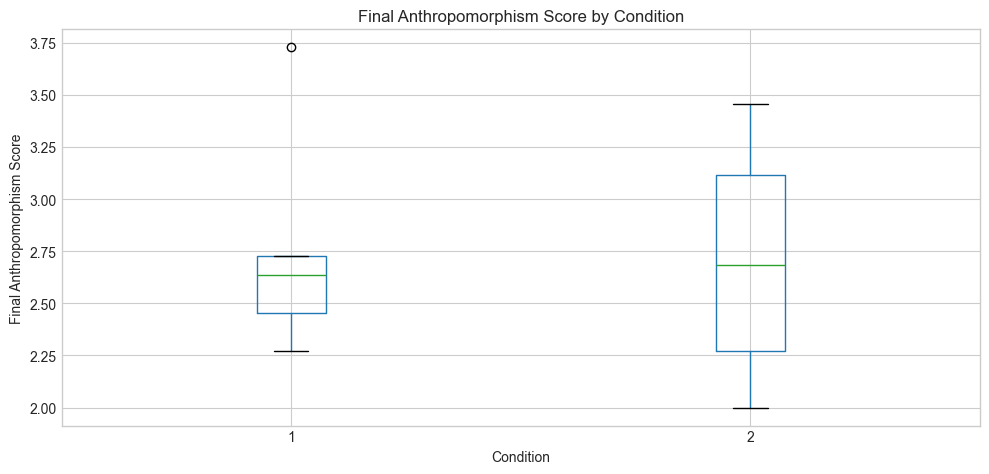

In [77]:
# display the box plot of the final anthropomorphism score by condition
fig4, ax4 = plt.subplots(figsize=(10, 5))
post_task.boxplot(column='final_anthropomorphism', by='condition', ax=ax4)
ax4.set_title('Final Anthropomorphism Score by Condition')
ax4.set_xlabel('Condition')
ax4.set_ylabel('Final Anthropomorphism Score')
plt.suptitle('')
plt.tight_layout()
plt.show()